<a href="https://colab.research.google.com/github/Wattsy2020/DeepLearningA1/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5329 Assignment 1

Team Member
- Mirope Yuhao Hu, SID: 470139936
- Sean Hongbo Du,	SID: 500635346
- Liam Watts, SID: 510562348

Experiments


*   Explicitly mention whether batchnorm eliminates the need for dropout
*   Check if 1 hidden layer gives better performance
*   Use cross validation for the top experiements. Include in the report an explanation about limitations of cross validation





## How to run the code

## All necessary Imports

__NOT__ allowed:
1. use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS)
2. any kinds of auto-grad tools (e.g. autograd)
3. sklearn

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from abc import ABCMeta, abstractmethod

# catch overflow errors, which usually occurs when weight explode
import warnings
warnings.simplefilter('error', RuntimeWarning)

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data -> subject to change for the final version
dir_name = '/content/drive/MyDrive/Colab Notebooks/COMP5329/Ass1/Assignment1-Dataset/'

test_data = np.load(dir_name + 'test_data.npy')
test_label = np.load(dir_name + 'test_label.npy')
train_data = np.load(dir_name + 'train_data.npy')
train_label = np.load(dir_name + 'train_label.npy')

print('Shape of original train data is:\t', train_data.shape,
      '\nShape of original train label is:\t', train_label.shape,
      '\nShape of original test data is:\t\t', test_data.shape,
      '\nShape of original test label is:\t', test_label.shape )

# one hot encoding the labels set 
def oneHot_encoder(data_label):
    '''returns the labels in one hot encoders'''
    encoded = list()
    for value in data_label:
        label_onehot = [0 for index in range(10)]
        label_onehot[int(value)] = 1
        encoded.append(label_onehot)
    return np.array(encoded)

test_x = test_data
train_x = train_data
test_y = oneHot_encoder(test_label)
train_y = oneHot_encoder(train_label)

print('\nShape of transformed train label is:\t', train_y.shape,
      '\nShape of transformed train label is:\t', test_y.shape )

Shape of original train data is:	 (50000, 128) 
Shape of original train label is:	 (50000, 1) 
Shape of original test data is:		 (10000, 128) 
Shape of original test label is:	 (10000, 1)

Shape of transformed train label is:	 (50000, 10) 
Shape of transformed train label is:	 (10000, 10)


(array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

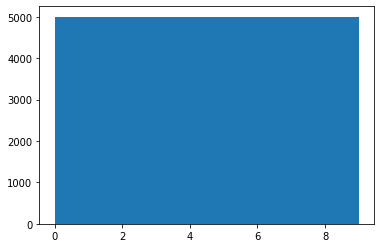

In [ ]:
# IS THIS MNIST? This seems like a version of mnist that has been cropped and/or compressed, potentially to 16x8 px format
# 50000 train and 10000 test data
# 10 labels (1 for each digit)
# Equal Distribution of labels
plt.hist(train_label, bins=10)

Plot of image 2471


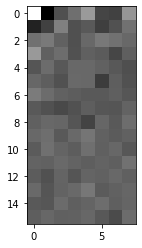

In [ ]:
i = int(np.random.rand(1)[0]*50000)
example = train_x[i].reshape(16, 8)
print("Plot of image {}".format(i))
plt.imshow(example, cmap="gray")

## Data Preprocessing



Data were normalized via dividing by the maximum positive number in the column.  

To visualize the dataset, the test data were transformed from (10000, 128) to (10000, 2, 64). According to the scatter plot of the nine classes, there is not much differences of the scatter plots between the classes. 

In [ ]:
# data normalization: [-1, 1]
def normalization(dataset):
    '''returns the normalized data'''
    numer = dataset - dataset.min(axis = 0)
    denom = dataset.max() - dataset.min()
    return numer/denom

# normalize the datasets
norm_train_data = normalization(train_data).transpose()
norm_test_data = normalization(test_data).transpose()

# reframe labels as DataFrame and renaming  
train_label_df = pd.DataFrame(train_label).rename(columns={0: "class"})
test_label_df = pd.DataFrame(test_label).rename(columns={0: "class"})

# combining data and labels as DataFrame
train_df = pd.concat([pd.DataFrame(norm_train_data), train_label_df.transpose()], axis=0).transpose()
test_df = pd.concat([pd.DataFrame(norm_test_data), test_label_df.transpose()], axis=0).transpose()


def pca_analysis(input_dat, num_components):
    '''returns the principal component analysis given the input data according to the number of components'''
    dat_mean = np.mean(input_dat, axis=0)
    # calculate the covariance matrix
    cov_matrix = np.cov(input_dat - dat_mean, rowvar=False)
    # calculation and manipulation on the eigens
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvectors = eigenvectors.transpose()
    sorted_components = np.argsort(eigenvalues)[::-1]
    # calculate the projection matrix
    proj_matrix = eigenvectors[sorted_components[:num_components]]
    return np.dot(input_dat - dat_mean, proj_matrix.transpose())

No handles with labels found to put in legend.


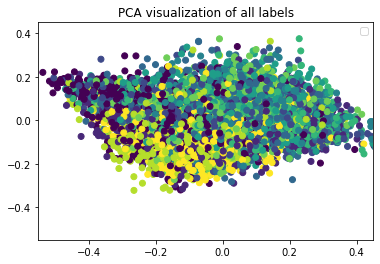

In [ ]:
# Plot of the PCA of all classes
pca = pca_analysis(test_df[test_df.columns[0:128]], 2)
plt.figure()
plt.scatter(pca[:, 0], pca[:, 1], c=test_df['class'])
plt.xlim(-0.55, 0.45)
plt.ylim(-0.55, 0.45)
plt.title("PCA visualization of all labels")
plt.legend()

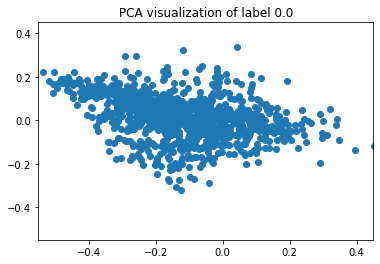

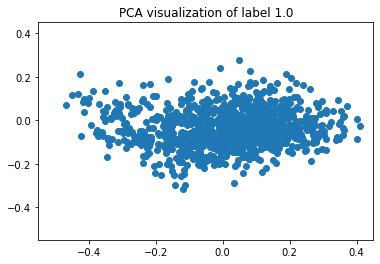

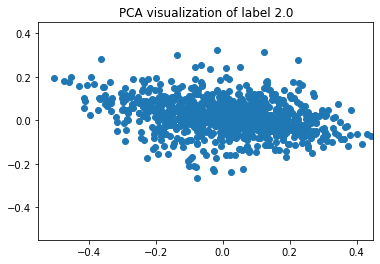

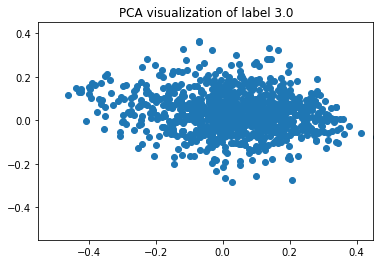

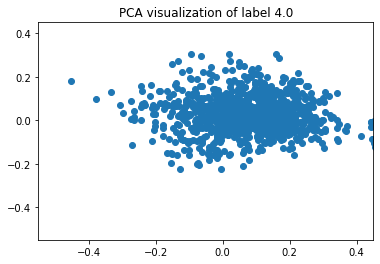

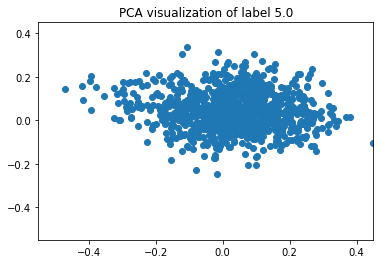

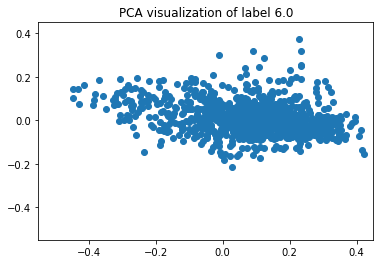

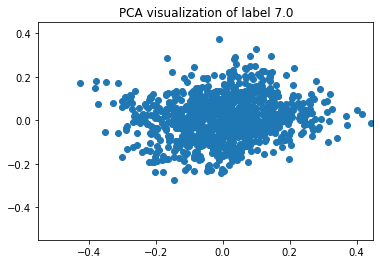

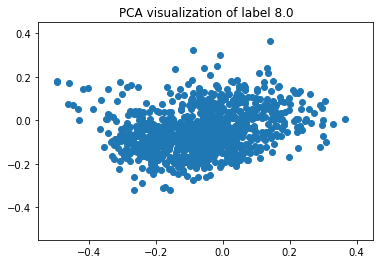

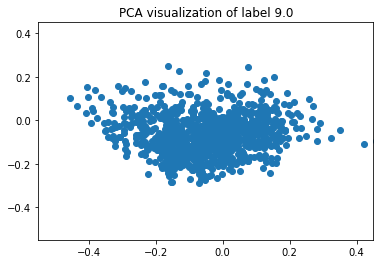

In [ ]:
# Plot of individual classes with the same PCA and equal chart scale
for num in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    data_pca = pca[test_df['class'] == num]
    plt.figure()
    plt.scatter(data_pca[:, 0], data_pca[:, 1])
    plt.title("PCA visualization of label {}".format(num))
    
    plt.xlim(-0.55, 0.45) # keep the scale the same for an equal comparison
    plt.ylim(-0.55, 0.45) # also keep scale the same for both axes
    plt.show()

## Algorithms / Structures

### Mathematical Functions

In [ ]:
# Define functions required for the Multi Layer Perceptron
def he_uniform(input_size=1, output_size=1):
    '''outputs a matrix of size (output_size, input_size) with random initialization'''
    r = np.sqrt(6/input_size)
    return np.random.uniform(-r, r, size=(output_size, input_size)).astype('float32')

def dropout_neurons(layer, dropout_rate = 0.5):
    '''returns the layers after dropout process'''
    neuron_num = int(layer.shape[0] * dropout_rate) # obtain the number of active input neurons
    neuron_ind = random.sample(range(0, layer.shape[0]), neuron_num) # obtain the indices of input active neurons
    # neuron_ind = sorted(neuron_ind) # sort the indices
    layer[neuron_ind] = 0
    return layer # return the active input neurons 

def accuracy(y_hat, y):
    preds = np.argmax(y_hat, axis=1)
    labels = np.argmax(y, axis=1)
    return np.mean(preds == labels)

### Structural Classes

#### Optimizer (Momentum + Weight Decay)

In [ ]:
# define the momentum optimizer class, the optimiser is passed in to every layer so it can update it's parameters during backprop
class Momentum():
    '''
    A momentum optimizer
    Attributes:
        self.learn_rate
        self.gamma - the momentum parameter that controls the contribution of the previous gradients to current gradient
    '''
    def __init__(self, learn_rate=1e-2, gamma=0.9, decay=0):
        self.learn_rate = learn_rate
        self.gamma = gamma
        self.decay = decay

    def __call__(self, weight, dloss, momentum_term, no_decay=False):
        '''calculate the weight update given the derivative of loss w.r.t. weight and previous momentum_term'''
        change = self.gamma * momentum_term + self.learn_rate * dloss
        if no_decay:
          weight -= change
        else: 
          weight = weight * (1 - self.decay) - change
        return weight, change

#### Base Layer + Linear Dense Layer

In [ ]:
# define the layer classes we'll use in the model, starting with an abstract base class
class layer(object, metaclass=ABCMeta):
    '''
    Base class for a layer.
    Attributes:
        self.input - the input to the layer
        self.activation - output of the layer (activation and input are for backprop so they can compute back propagation with only the derivative of loss w.r.t. their output)
        layers should define momentum attributes themselves

    Layers must define
        forward(X, train=True): a feed forward function that both returns output and stores it in self.activation. If train=True dropout will be used, and the behaviour of batchnorm changes
        backprop(dloss, optimizer, output_dloss=True): a back propagation function, both updates the weights of the layer and (unless specificied otherwise) returns the losses for the layers inputs 
    '''
    def __init__(self):
        self.input = []
        self.activation = []
    
    @abstractmethod
    def forward(self, X, train=True):
        pass

    @abstractmethod
    def backprop(self, dloss, optimizer, output_dloss=True):
        pass

class linear(layer):
    '''Defines a linear layer, parameters: input size, output size, initializer'''
    def __init__(self, n_input, n_output, initializer=he_uniform):
        super().__init__()
        self.weights = initializer(input_size=n_input, output_size=n_output)
        self.biases = np.zeros((n_output, 1))

        # store momentum terms in the layer, implementing a torch style optimizer class is infeasible
        self.w_momentum = np.zeros((n_output, n_input)) 
        self.b_momentum = np.zeros((n_output, 1))

    def forward(self, X, train=True):
        self.input = X
        self.activation = np.dot(X, self.weights.T) + self.biases.T
        return self.activation.astype('float32')

    def backprop(self, dloss, optimizer, output_dloss=True):
        '''
        backpropagate the linear layer
        parameters:
            dloss: loss of the output (pre relu) of this layer, shape of (batch_size, layer_output_size)
            optimizer: an optimizer class, optimizer(dloss w.r.t. weights , momentum) returns the weight_change

        returns:
            dloss: loss of the output (pre relu) of the previous layer (layer i-1), so long as layer i-1 exists (i.e. i-1 >= 0)
        '''
        assert dloss is not None, "Output deltas not provided"

        # outline dimensions
        batch_size = dloss.shape[0]
        layer_output_size = dloss.shape[1]
        layer_input_size = self.input.shape[-1]
        
        # calculate gradients
        self.input = self.input.reshape(batch_size, layer_input_size) # use reshapes to assert the shape is correct, and indicate shape
        dw = np.dot(dloss.T, self.input).reshape(layer_output_size, layer_input_size)
        # the i,j entry of dw represents the dot product of:
        # the ith row of dloss.T i.e. the derivative of losses for neuron i over all samples
        # the jth column of activation i.e. the input to weight j over all samples
        # so overall: it is (dloss for neuron i * input for weight j of neuron i), giving us the derivative of loss w.r.t weight i,j
        db = np.sum(dloss.T, axis=1).reshape(layer_output_size, 1)
        # output = X*W.T + B so doutput w.r.t db is just 1, hence we only need to sum the gradients for each bias
        
        # calculate gradient of loss w.r.t output of previous layer (if there is a previous layer)
        if output_dloss:
            dloss_prev = np.dot(dloss, self.weights).reshape(batch_size, layer_input_size)
            # the i,j entry of dloss_prev represents the dot product of
            # the ith row of dloss i.e. the dlosses for the ith sample for each of this layers outputs
            # the jth column of W i.e. the jth weight for all output neurons in this layer
            # overall: the sum of (dloss of output neuron k * weight j (the weight that multiplies input j) of output neuron k for sample i)
            # which is the derivative of the loss w.r.t input j for this sample as output = X*W.T + B
        else:
            dloss_prev = None

        # update gradients, with weight decay and momentum 
        self.weights, self.w_momentum = optimizer(self.weights, (1/batch_size) * dw, self.w_momentum)
        self.biases, self.b_momentum = optimizer(self.biases, (1/batch_size) * db, self.b_momentum, no_decay=True)

        return dloss_prev

#### Batch-Normalised Layer

In [ ]:
class Batchnorm(layer):
    '''implements batch normalization as a parametric layer, requires number of inputs, refer to https://arxiv.org/pdf/1502.03167.pdf for details'''
    def __init__(self, n_input, initializer=he_uniform, epsilon=1e-5, alpha=0.9):
        super().__init__()
        self.n_input = n_input
        self.gamma = np.ones((1, n_input)) # the trainable scalar parameters
        self.beta =  np.zeros((1, n_input)) # the trainable bias parameters
        self.mean =  np.zeros((1, n_input)) # minibatch (or train set) mean
        self.var  =  np.zeros((1, n_input)) # minibatch (or train set) variance
        self.epsilon = epsilon # used to prevent division by 0
        self.g_momentum = np.ones((1, n_input))
        self.b_momentum = np.zeros((1, n_input))

        # the mean and variance for the dataset, estimated using an exponential mean
        self.alpha = alpha
        self.emean = np.zeros((1, n_input))
        self.evar   = np.zeros((1, n_input))

    def forward(self, X, train=True):
        '''forward propagate, also take the exponential mean of mean and variance on the mini batches which will be used in testing'''
        self.input = X
        if train:
            # first calculate several variables, these are reused in backprop so it is useful to store them for later
            self.mean = np.mean(X, axis=0) # the mean of output of each neuron (each column is a neurons output)
            self.var = np.var(X, axis=0)
            self.invdev = np.power(self.var + self.epsilon, -1/2)
            self.inputdifmean = self.input - self.mean

            # update the estimated mean and variance of the entire dataset
            self.emean = self.alpha*self.emean + (1 - self.alpha)*self.mean
            self.evar  = self.alpha*self.evar  + (1 - self.alpha)*self.var

            # perform batchnorm
            self.xhat = (X - self.mean) * np.power(self.var + self.epsilon, -1/2)
        else:
            # perform batchnorm using the estimated mean and variance
            self.xhat = (X - self.emean) * np.power(self.evar + self.epsilon, -1/2)
        
        self.activation = self.gamma * self.xhat + self.beta
        return self.activation

    def backprop(self, dloss, optimizer, output_dloss=True):
        '''backprop, updating the gamma and beta parameters algorithm taken from https://arxiv.org/pdf/1502.03167.pdf '''
        batch_size = dloss.shape[0]

        # note d___ means derivative of loss w.r.t ___
        dxhat = (dloss * self.gamma).reshape(batch_size, self.n_input)
        dvar  = (-1/2) * np.sum(dxhat * (self.inputdifmean)*np.power(self.invdev, 3), axis=0).reshape(1, self.n_input)
        dbias = (np.sum(dxhat*-1*self.invdev, axis=0) + (-2*dvar*np.mean(self.inputdifmean, axis=0))).reshape(1, self.n_input)
        dprev = (dxhat*self.invdev + dvar*(2/batch_size)*self.inputdifmean + dbias/batch_size).reshape(batch_size, self.n_input)
        dgamma = np.sum(dloss * self.xhat, axis=0)
        dbeta = np.sum(dloss)

        # update the trainable parameters
        self.gamma, self.g_momentum = optimizer(self.gamma, (1/batch_size) * dgamma, self.g_momentum)
        self.beta, self.b_momentum = optimizer(self.beta, (1/batch_size) * dbeta, self.b_momentum, no_decay=True)

        return dprev

#### Dropout Layer

In [ ]:
class Dropout(layer):
    '''implements dropout as a layer (with no parameters)'''
    def __init__(self, drop_prob=0):
        super().__init__()
        self.drop_prob = drop_prob
        self.drop_vector = None # vector of 0 if neuron i is dropped, 1 if neuron i is kept

    def forward(self, X, train=True):
        '''dropout neurons, if train=True'''
        self.input = X
        if train:
            self.drop_vector = (np.random.random((X.shape[1], 1)) > self.drop_prob).astype(int) # a random uniform variable in [0, 1) is < self.drop_prob self.drop_prob % of the time
            self.activation = X*self.drop_vector.T # drop the specified neurons using broadcasting
        else:
            self.activation = X*(1 - self.drop_prob) # the paper says when not using dropout we multiply by the keep prob to keep the overall magnitude of the output the same
        return self.activation.astype('float32')

    def backprop(self, dloss, optimizer, output_dloss=True):
        '''calculate derivative of dropout, this is just zeroing the gradients of the neurons that were dropped'''
        if output_dloss:
            return dloss * self.drop_vector.T

#### Activation Layers (ReLu + Softmax + Cross Entrophy)

In [ ]:
# define relu and softmax as layers with no parameters, this way the model can be defined entirely with modular layers
class ReLU(layer):
    '''implements relu activation function as a layer (with no parameters)'''
    def __init__(self):
        super().__init__()

    def forward(self, X, train=True):
        self.input = X
        self.activation = np.maximum(self.input, 0)
        return self.activation.astype('float32')

    def backprop(self, dloss, optimizer, output_dloss=True):
        '''this defines the derivative of relu at 0 as 0 to tf.nn.relu()'s standard (which ensures a sparser gradient matrix)'''
        if output_dloss:
            return (self.input > 0).astype(int) * dloss

class Softmax(layer):
    '''implements softmax activation function as a layer (with no parameters)'''
    def __init__(self):
        super().__init__()

    def forward(self, X, train=True):
        '''return the softmax activation of a matrix (each row vector has softmax applied to it)'''
        self.input = X
        X = np.power(np.e, X)

        total = np.sum(X, axis=1).reshape(X.shape[0], 1)
        self.activation = X/total
        return self.activation.astype('float32')

    def backprop(self, dloss, optimizer, output_dloss=True):
        '''
        calculate derivative of softmax activation
        note this function assumes softmax is the output activation, and that dloss is the ground truth labels
        see https://peterroelants.github.io/posts/cross-entropy-softmax/ for an explanation of this derivative
        '''
        if output_dloss:
            return self.activation - dloss

### MLP Base Class (>1 hidden layer)

In [ ]:
class MLP:
    ''' 
    Implements a Multi Layer Perceptron, including both the feed-forward phase and backward propagation
    The hidden activation is ReLU, output activation is softmax, and the loss function cross entropy
    Store all parts of the networks in self.layers: an array of Layer classes

    MLP.__init__()
        parameters:
            hidden: an array with the number of neurons for each layer
            input_size: number of inputs
            output_size: number of outputs
            output_act: the activation for the last layer, one of sigmoid or softmax
            momentum_gamma: the momentum term
        
        initializes weight matrices with shape (output_size, input_size) to match Pytorch's standard
    '''
    def __init__(self, 
                 hidden=[1], input_size=1, output_size=1, 
                 learn_rate=1e-2, weight_decay=1e-3, momentum_gamma=0.9, batch_norm=False,
                 dropout_rate=0, initializer=he_uniform): ####
        '''initialize the layers, optimizer and other hyperparameters'''
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate
        
        self.optimizer = Momentum(learn_rate=learn_rate, gamma=momentum_gamma, decay=weight_decay)

        self.layers = [] # this stores linear, activation functions, dropout and batchnorm as layers
        for i, (input_size_i, output_size_i) in enumerate(zip([input_size] + hidden, hidden + [output_size])):
            self.layers.append(linear(input_size_i, output_size_i, initializer=initializer))
            # if batch_norm: # add batch-norm layer before the activation func according to the paper
            #     self.layers.append(bn_layer(output_size_i, output_size_i, initializer=initializer))
            if i == len(hidden): # use softmax activation in last layer
                self.layers.append(Softmax())
            else:
                self.layers.append(ReLU())
                if dropout_rate > 0:
                    self.layers.append(Dropout(drop_prob=dropout_rate))
                if batch_norm: # we use batchnorm after the activation to encourage sparseness
                    self.layers.append(Batchnorm(output_size_i, initializer=initializer))
    
    def forward(self, X, train=True):
        '''
        calculate output of the network
        
        parameters:
            X: the input matrix of shape (batch_size, input_size)
            train: if True the model will use dropout, also affects batchnorm

        returns:
            yhat: the prediction matrix of shape (batch_size, output_size)
        '''
        for layer in self.layers:
            X = layer.forward(X, train=train)
        return X

    def backprop(self, y):
        '''given the true outputs y perform one step of gradient descent using the predictions of the current batch as yhat'''
        dloss = y # the softmax layer expects the ground truth to be passed in
        for layer in reversed(self.layers[1:]): # backprop until the first layer
            dloss = layer.backprop(dloss, self.optimizer)
        layer.backprop(dloss, self.optimizer, output_dloss=False) # to save time don't calculate the loss on the training data

    def __repr__(self):
        return self.layers.__repr__()

## Experiments


By far the most helpful method might be:

- momentum

### Experiment Settings (Table)

To conduct and record experiments in a trackable manner, we created a table with log Id as follows:

| LogID | hidden | epoch | batch size | learning rate | weight decay | momentum | dropout | batch norm |
|:--|:---------|:---|:---|:---|:---|:---|:---|:---|
| 0 | [64, 32] | 50 | 128 | 1e-3 | 0 | 0 | 0 | False |
| 0_1 | [64, 32] | 50 | 128 | 1e-3 | 0 | 0.9 | 0 | False |
| 1 | [128, 64] | 50 | 128 | 1e-3 | 0 | 0 | 0 | False |
| 1_1 | [128] | 50 | 128 | 1e-3 | 0 | 0 | 0 | False |
| 2 | [256, 128] | 50 | 128 | 1e-3 | 0 | 0 | 0 | False |
| 2_1 | [256] | 50 | 128 | 1e-3 | 0 | 0 | 0 | False |
| 3 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0 | 0 | False |
| 3_1 | [256, 128] | 50 | 32 | 1e-3 | 0 | 0 | 0 | False |
| 3_2 | [256, 128] | 50 | 16 | 1e-3 | 0 | 0 | 0 | False |
| 4 | [256, 128] | 50 | 256 | 1e-3 | 0 | 0 | 0 | False |
| 5 | [64, 32] | 50 | 1 | 1e-3 | 0 | 0 | 0 | False |
| 6 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.9 | 0 | False |
| 7 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.95 | 0 | False |
| 8 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.5 | 0 | False |
| 9 | [256, 128] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0 | False |
| 9_1 | [256, 128] | 50 | 64 | 1e-2 | 1e-4 | 0.9 | 0 | False |
| 10 | [256, 128] | 50 | 64 | 1e-3 | 1e-3 | 0.9 | 0 | False |
| 10_1 | [256, 128] | 50 | 64 | 1e-3 | 1e-5 | 0.9 | 0 | False |
| 11 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.9 | 0.2 | False |
| 12 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.9 | 0.3 | False |
| 12_1 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.9 | 0.1 | False |
| 13 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.95 | 0.2 | False |
| 13_1 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.95 | 0.1 | False |
| 14 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.9 | 0 | True |
| 15 | [64, 32] | 50 | 1 | 1e-3 | 0 | 0.9 | 0 | False |
| 16 | [256, 128] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0.1 | True |
| 17 | [256, 128] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0 | True |
| 17_1 | [256, 128, 64] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0 | True |
| 17_2 | [512, 128] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0 | True |
| 17_3* | [512, 256] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0 | True |
| 17_4 | [512, 256]  | 50 | 32 | 1e-3 | 1e-4 | 0.9 | 0 | True |
| 18 | [256, 128] | 50 | 64 | 1e-3 | 0 | 0.9 | 0.2 | True |
| 19 | [256] | 50 | 64 | 1e-3 | 1e-4 | 0.9 | 0 | True |

### Experiment Codes

#### Base Function for experiment (Mini-Batch Training)

In [ ]:
def experiment(hid=[128], ep=50, bs=128, lr=1e-3, wd=0, m=0.9, dr=0, bn=False):
  
    mlp = MLP(hidden=hid, input_size=128, output_size=10, learn_rate=lr, weight_decay=wd, 
              momentum_gamma=m, batch_norm=bn, dropout_rate=dr)
    
    train_acc_log = []
    test_acc_log = []
    time_log = []
    X = train_x
    y = train_y

    start_t = time.time()
    for epo in range(ep):
        epo_start = time.time()
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices) # shuffle the trainning data for each 
        X = X[indices, :]
        y = y[indices, :]

        for batch in range(int(X.shape[0]/bs)):
            batch_x = X[batch*bs:(batch+1)*bs]
            batch_y = y[batch*bs:(batch+1)*bs]
            preds = mlp.forward(batch_x)
            mlp.backprop(batch_y)

        train_acc = accuracy(mlp.forward(X, train=False), y)
        test_acc = accuracy(mlp.forward(test_x, train=False), test_y)
        epo_time = time.time() - epo_start
        time_log.append(epo_time)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        if epo % 5 == 0:
            print("Epoch {:04d}\tTrain Accuracy: {:.4f}\tTest Accuracy: {:.4f}\t{:.2f}s for this epoch"
            .format(epo, train_acc, test_acc, epo_time))
    print('-------')
    print('Final:\t\tTrain Accuracy: {:.4f}\tTest Accuracy: {:.4f}\n\t\tOverall time {:.2f}s\tAve {:.2f}s for each epoch'
    .format(train_acc, test_acc, time.time()-start_t, np.mean(time_log)))

    log = (epoch, train_acc_log, test_acc_log, time_log)
    return log

#### The Best Performing Experiment

#### All Experiments

In [ ]:
### log0
epoch = 50
batch_size = 128
hidden = [64, 32]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log0 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1315	Test Accuracy: 0.1310	0.64s for this epoch
Epoch 0005	Train Accuracy: 0.1756	Test Accuracy: 0.1704	0.57s for this epoch
Epoch 0010	Train Accuracy: 0.2100	Test Accuracy: 0.2047	0.52s for this epoch
Epoch 0015	Train Accuracy: 0.2346	Test Accuracy: 0.2332	0.56s for this epoch
Epoch 0020	Train Accuracy: 0.2519	Test Accuracy: 0.2499	0.54s for this epoch
Epoch 0025	Train Accuracy: 0.2642	Test Accuracy: 0.2632	0.56s for this epoch
Epoch 0030	Train Accuracy: 0.2732	Test Accuracy: 0.2744	0.55s for this epoch
Epoch 0035	Train Accuracy: 0.2826	Test Accuracy: 0.2819	0.61s for this epoch
Epoch 0040	Train Accuracy: 0.2890	Test Accuracy: 0.2904	0.53s for this epoch
Epoch 0045	Train Accuracy: 0.2946	Test Accuracy: 0.2978	0.53s for this epoch
-------
Final:		Train Accuracy: 0.2988	Test Accuracy: 0.3017
		Overall time 27.55s	Ave 0.55s for each epoch


In [ ]:
### log0_1 with momentum to compare with 15 & 5
epoch = 50
batch_size = 128
hidden = [64, 32]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log0_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1939	Test Accuracy: 0.2038	0.59s for this epoch
Epoch 0005	Train Accuracy: 0.2930	Test Accuracy: 0.2944	0.53s for this epoch
Epoch 0010	Train Accuracy: 0.3201	Test Accuracy: 0.3197	0.54s for this epoch
Epoch 0015	Train Accuracy: 0.3353	Test Accuracy: 0.3353	0.53s for this epoch
Epoch 0020	Train Accuracy: 0.3451	Test Accuracy: 0.3393	0.52s for this epoch
Epoch 0025	Train Accuracy: 0.3524	Test Accuracy: 0.3491	0.52s for this epoch
Epoch 0030	Train Accuracy: 0.3589	Test Accuracy: 0.3527	0.56s for this epoch
Epoch 0035	Train Accuracy: 0.3643	Test Accuracy: 0.3587	0.51s for this epoch
Epoch 0040	Train Accuracy: 0.3688	Test Accuracy: 0.3632	0.54s for this epoch
Epoch 0045	Train Accuracy: 0.3713	Test Accuracy: 0.3661	0.51s for this epoch
-------
Final:		Train Accuracy: 0.3749	Test Accuracy: 0.3681
		Overall time 26.76s	Ave 0.54s for each epoch


In [ ]:
### log1
epoch = 50
batch_size = 128
hidden = [128, 64]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1345	Test Accuracy: 0.1340	1.03s for this epoch
Epoch 0005	Train Accuracy: 0.2343	Test Accuracy: 0.2335	0.92s for this epoch
Epoch 0010	Train Accuracy: 0.2669	Test Accuracy: 0.2656	0.95s for this epoch
Epoch 0015	Train Accuracy: 0.2892	Test Accuracy: 0.2850	0.93s for this epoch
Epoch 0020	Train Accuracy: 0.3052	Test Accuracy: 0.2989	0.94s for this epoch
Epoch 0025	Train Accuracy: 0.3171	Test Accuracy: 0.3128	0.91s for this epoch
Epoch 0030	Train Accuracy: 0.3282	Test Accuracy: 0.3237	0.97s for this epoch
Epoch 0035	Train Accuracy: 0.3355	Test Accuracy: 0.3297	0.91s for this epoch
Epoch 0040	Train Accuracy: 0.3428	Test Accuracy: 0.3360	0.95s for this epoch
Epoch 0045	Train Accuracy: 0.3477	Test Accuracy: 0.3433	0.92s for this epoch
-------
Final:		Train Accuracy: 0.3521	Test Accuracy: 0.3475
		Overall time 46.99s	Ave 0.94s for each epoch


In [ ]:
### log1_1
epoch = 50
batch_size = 128
hidden = [128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log1_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1285	Test Accuracy: 0.1270	0.58s for this epoch
Epoch 0005	Train Accuracy: 0.2230	Test Accuracy: 0.2245	0.57s for this epoch
Epoch 0010	Train Accuracy: 0.2656	Test Accuracy: 0.2661	0.58s for this epoch
Epoch 0015	Train Accuracy: 0.2883	Test Accuracy: 0.2876	0.58s for this epoch
Epoch 0020	Train Accuracy: 0.3041	Test Accuracy: 0.3034	0.58s for this epoch
Epoch 0025	Train Accuracy: 0.3156	Test Accuracy: 0.3162	0.56s for this epoch
Epoch 0030	Train Accuracy: 0.3257	Test Accuracy: 0.3242	0.56s for this epoch
Epoch 0035	Train Accuracy: 0.3333	Test Accuracy: 0.3315	0.56s for this epoch
Epoch 0040	Train Accuracy: 0.3404	Test Accuracy: 0.3358	0.57s for this epoch
Epoch 0045	Train Accuracy: 0.3462	Test Accuracy: 0.3415	0.58s for this epoch
-------
Final:		Train Accuracy: 0.3506	Test Accuracy: 0.3460
		Overall time 28.90s	Ave 0.58s for each epoch


In [ ]:
### log2
epoch = 50
batch_size = 128
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log2 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1732	Test Accuracy: 0.1768	1.85s for this epoch
Epoch 0005	Train Accuracy: 0.2776	Test Accuracy: 0.2845	1.79s for this epoch
Epoch 0010	Train Accuracy: 0.3154	Test Accuracy: 0.3142	1.84s for this epoch
Epoch 0015	Train Accuracy: 0.3373	Test Accuracy: 0.3328	1.78s for this epoch
Epoch 0020	Train Accuracy: 0.3529	Test Accuracy: 0.3504	1.88s for this epoch
Epoch 0025	Train Accuracy: 0.3646	Test Accuracy: 0.3594	1.80s for this epoch
Epoch 0030	Train Accuracy: 0.3725	Test Accuracy: 0.3680	1.77s for this epoch
Epoch 0035	Train Accuracy: 0.3806	Test Accuracy: 0.3754	1.78s for this epoch
Epoch 0040	Train Accuracy: 0.3868	Test Accuracy: 0.3813	1.79s for this epoch
Epoch 0045	Train Accuracy: 0.3933	Test Accuracy: 0.3851	1.78s for this epoch
-------
Final:		Train Accuracy: 0.3976	Test Accuracy: 0.3890
		Overall time 90.55s	Ave 1.81s for each epoch


In [ ]:
### log2_1
epoch = 50
batch_size = 128
hidden = [256]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log2_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1466	Test Accuracy: 0.1541	1.01s for this epoch
Epoch 0005	Train Accuracy: 0.2640	Test Accuracy: 0.2709	0.99s for this epoch
Epoch 0010	Train Accuracy: 0.3075	Test Accuracy: 0.3076	0.98s for this epoch
Epoch 0015	Train Accuracy: 0.3297	Test Accuracy: 0.3265	0.99s for this epoch
Epoch 0020	Train Accuracy: 0.3452	Test Accuracy: 0.3412	0.98s for this epoch
Epoch 0025	Train Accuracy: 0.3580	Test Accuracy: 0.3530	1.00s for this epoch
Epoch 0030	Train Accuracy: 0.3679	Test Accuracy: 0.3620	0.99s for this epoch
Epoch 0035	Train Accuracy: 0.3748	Test Accuracy: 0.3725	0.98s for this epoch
Epoch 0040	Train Accuracy: 0.3808	Test Accuracy: 0.3768	0.98s for this epoch
Epoch 0045	Train Accuracy: 0.3861	Test Accuracy: 0.3835	1.02s for this epoch
-------
Final:		Train Accuracy: 0.3903	Test Accuracy: 0.3872
		Overall time 49.64s	Ave 0.99s for each epoch


In [ ]:
### log3
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log3 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.2275	Test Accuracy: 0.2252	2.18s for this epoch
Epoch 0005	Train Accuracy: 0.3337	Test Accuracy: 0.3296	2.08s for this epoch
Epoch 0010	Train Accuracy: 0.3658	Test Accuracy: 0.3613	2.13s for this epoch
Epoch 0015	Train Accuracy: 0.3862	Test Accuracy: 0.3776	2.11s for this epoch
Epoch 0020	Train Accuracy: 0.3991	Test Accuracy: 0.3948	2.10s for this epoch
Epoch 0025	Train Accuracy: 0.4083	Test Accuracy: 0.4026	2.05s for this epoch
Epoch 0030	Train Accuracy: 0.4170	Test Accuracy: 0.4101	2.11s for this epoch
Epoch 0035	Train Accuracy: 0.4239	Test Accuracy: 0.4162	2.04s for this epoch
Epoch 0040	Train Accuracy: 0.4289	Test Accuracy: 0.4204	2.07s for this epoch
Epoch 0045	Train Accuracy: 0.4340	Test Accuracy: 0.4233	2.07s for this epoch
-------
Final:		Train Accuracy: 0.4380	Test Accuracy: 0.4264
		Overall time 104.54s	Ave 2.09s for each epoch


In [ ]:
### log3_1
epoch = 50
batch_size = 32
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log3_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.2583	Test Accuracy: 0.2640	2.72s for this epoch
Epoch 0005	Train Accuracy: 0.3667	Test Accuracy: 0.3640	2.63s for this epoch
Epoch 0010	Train Accuracy: 0.3961	Test Accuracy: 0.3903	2.69s for this epoch
Epoch 0015	Train Accuracy: 0.4144	Test Accuracy: 0.4034	2.61s for this epoch
Epoch 0020	Train Accuracy: 0.4283	Test Accuracy: 0.4181	2.65s for this epoch
Epoch 0025	Train Accuracy: 0.4395	Test Accuracy: 0.4266	2.62s for this epoch
Epoch 0030	Train Accuracy: 0.4466	Test Accuracy: 0.4336	2.64s for this epoch
Epoch 0035	Train Accuracy: 0.4545	Test Accuracy: 0.4343	2.68s for this epoch
Epoch 0040	Train Accuracy: 0.4597	Test Accuracy: 0.4396	2.69s for this epoch
Epoch 0045	Train Accuracy: 0.4660	Test Accuracy: 0.4395	2.73s for this epoch
-------
Final:		Train Accuracy: 0.4693	Test Accuracy: 0.4450
		Overall time 133.31s	Ave 2.67s for each epoch


In [ ]:
### log3_2
epoch = 50
batch_size = 16
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log3_2 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3063	Test Accuracy: 0.3095	3.94s for this epoch
Epoch 0005	Train Accuracy: 0.3973	Test Accuracy: 0.3910	3.88s for this epoch
Epoch 0010	Train Accuracy: 0.4255	Test Accuracy: 0.4152	3.97s for this epoch
Epoch 0015	Train Accuracy: 0.4419	Test Accuracy: 0.4339	3.87s for this epoch
Epoch 0020	Train Accuracy: 0.4542	Test Accuracy: 0.4388	3.88s for this epoch
Epoch 0025	Train Accuracy: 0.4651	Test Accuracy: 0.4492	3.83s for this epoch
Epoch 0030	Train Accuracy: 0.4750	Test Accuracy: 0.4560	3.84s for this epoch
Epoch 0035	Train Accuracy: 0.4835	Test Accuracy: 0.4600	3.86s for this epoch
Epoch 0040	Train Accuracy: 0.4924	Test Accuracy: 0.4671	3.87s for this epoch
Epoch 0045	Train Accuracy: 0.4988	Test Accuracy: 0.4708	3.80s for this epoch
-------
Final:		Train Accuracy: 0.5040	Test Accuracy: 0.4699
		Overall time 193.88s	Ave 3.88s for each epoch


In [ ]:
### log4
epoch = 50
batch_size = 256
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log4 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.1339	Test Accuracy: 0.1356	1.90s for this epoch
Epoch 0005	Train Accuracy: 0.2384	Test Accuracy: 0.2408	1.80s for this epoch
Epoch 0010	Train Accuracy: 0.2803	Test Accuracy: 0.2808	1.76s for this epoch
Epoch 0015	Train Accuracy: 0.3035	Test Accuracy: 0.3054	1.77s for this epoch
Epoch 0020	Train Accuracy: 0.3199	Test Accuracy: 0.3219	1.78s for this epoch
Epoch 0025	Train Accuracy: 0.3320	Test Accuracy: 0.3331	1.79s for this epoch
Epoch 0030	Train Accuracy: 0.3416	Test Accuracy: 0.3427	1.84s for this epoch
Epoch 0035	Train Accuracy: 0.3495	Test Accuracy: 0.3505	1.79s for this epoch
Epoch 0040	Train Accuracy: 0.3566	Test Accuracy: 0.3577	1.74s for this epoch
Epoch 0045	Train Accuracy: 0.3620	Test Accuracy: 0.3632	1.75s for this epoch
-------
Final:		Train Accuracy: 0.3668	Test Accuracy: 0.3668
		Overall time 89.12s	Ave 1.78s for each epoch


In [ ]:
### log5
epoch = 50
batch_size = 1
hidden = [64, 32]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0
dropout_rate = 0
batch_norm = False

log5 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3399	Test Accuracy: 0.3353	7.17s for this epoch
Epoch 0005	Train Accuracy: 0.3877	Test Accuracy: 0.3842	7.20s for this epoch
Epoch 0010	Train Accuracy: 0.4036	Test Accuracy: 0.3944	7.17s for this epoch
Epoch 0015	Train Accuracy: 0.4075	Test Accuracy: 0.3988	7.28s for this epoch
Epoch 0020	Train Accuracy: 0.4106	Test Accuracy: 0.4015	7.28s for this epoch
Epoch 0025	Train Accuracy: 0.4154	Test Accuracy: 0.3990	7.15s for this epoch
Epoch 0030	Train Accuracy: 0.4146	Test Accuracy: 0.4013	7.17s for this epoch
Epoch 0035	Train Accuracy: 0.4191	Test Accuracy: 0.4076	7.15s for this epoch
Epoch 0040	Train Accuracy: 0.4216	Test Accuracy: 0.4090	7.22s for this epoch
Epoch 0045	Train Accuracy: 0.4202	Test Accuracy: 0.4054	7.10s for this epoch
-------
Final:		Train Accuracy: 0.4242	Test Accuracy: 0.4138
		Overall time 359.20s	Ave 7.18s for each epoch


In [ ]:
### log6
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log6 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3564	Test Accuracy: 0.3538	2.12s for this epoch
Epoch 0005	Train Accuracy: 0.4446	Test Accuracy: 0.4278	2.09s for this epoch
Epoch 0010	Train Accuracy: 0.4747	Test Accuracy: 0.4485	2.06s for this epoch
Epoch 0015	Train Accuracy: 0.4970	Test Accuracy: 0.4601	2.15s for this epoch
Epoch 0020	Train Accuracy: 0.5095	Test Accuracy: 0.4608	2.09s for this epoch
Epoch 0025	Train Accuracy: 0.5238	Test Accuracy: 0.4769	2.15s for this epoch
Epoch 0030	Train Accuracy: 0.5346	Test Accuracy: 0.4751	2.12s for this epoch
Epoch 0035	Train Accuracy: 0.5445	Test Accuracy: 0.4802	2.09s for this epoch
Epoch 0040	Train Accuracy: 0.5523	Test Accuracy: 0.4816	2.06s for this epoch
Epoch 0045	Train Accuracy: 0.5644	Test Accuracy: 0.4853	2.08s for this epoch
-------
Final:		Train Accuracy: 0.5711	Test Accuracy: 0.4833
		Overall time 104.96s	Ave 2.10s for each epoch


In [ ]:
### log7
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.95
dropout_rate = 0
batch_norm = False

log7 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3845	Test Accuracy: 0.3772	2.10s for this epoch
Epoch 0005	Train Accuracy: 0.4683	Test Accuracy: 0.4395	2.06s for this epoch
Epoch 0010	Train Accuracy: 0.5051	Test Accuracy: 0.4609	2.06s for this epoch
Epoch 0015	Train Accuracy: 0.5317	Test Accuracy: 0.4738	2.07s for this epoch
Epoch 0020	Train Accuracy: 0.5499	Test Accuracy: 0.4781	2.06s for this epoch
Epoch 0025	Train Accuracy: 0.5691	Test Accuracy: 0.4821	2.09s for this epoch
Epoch 0030	Train Accuracy: 0.5820	Test Accuracy: 0.4804	2.07s for this epoch
Epoch 0035	Train Accuracy: 0.5969	Test Accuracy: 0.4819	2.07s for this epoch
Epoch 0040	Train Accuracy: 0.6063	Test Accuracy: 0.4818	2.05s for this epoch
Epoch 0045	Train Accuracy: 0.6192	Test Accuracy: 0.4778	2.11s for this epoch
-------
Final:		Train Accuracy: 0.6278	Test Accuracy: 0.4812
		Overall time 103.67s	Ave 2.07s for each epoch


In [ ]:
### log8
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.5
dropout_rate = 0
batch_norm = False

log8 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.2555	Test Accuracy: 0.2566	2.09s for this epoch
Epoch 0005	Train Accuracy: 0.3646	Test Accuracy: 0.3640	2.06s for this epoch
Epoch 0010	Train Accuracy: 0.3959	Test Accuracy: 0.3889	2.06s for this epoch
Epoch 0015	Train Accuracy: 0.4139	Test Accuracy: 0.4042	2.09s for this epoch
Epoch 0020	Train Accuracy: 0.4266	Test Accuracy: 0.4175	2.05s for this epoch
Epoch 0025	Train Accuracy: 0.4366	Test Accuracy: 0.4260	2.07s for this epoch
Epoch 0030	Train Accuracy: 0.4440	Test Accuracy: 0.4328	2.09s for this epoch
Epoch 0035	Train Accuracy: 0.4511	Test Accuracy: 0.4384	2.03s for this epoch
Epoch 0040	Train Accuracy: 0.4587	Test Accuracy: 0.4434	2.13s for this epoch
Epoch 0045	Train Accuracy: 0.4645	Test Accuracy: 0.4489	2.08s for this epoch
-------
Final:		Train Accuracy: 0.4690	Test Accuracy: 0.4502
		Overall time 103.75s	Ave 2.07s for each epoch


In [ ]:
### log9
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log9 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3543	Test Accuracy: 0.3495	2.11s for this epoch
Epoch 0005	Train Accuracy: 0.4360	Test Accuracy: 0.4271	2.08s for this epoch
Epoch 0010	Train Accuracy: 0.4565	Test Accuracy: 0.4434	2.05s for this epoch
Epoch 0015	Train Accuracy: 0.4666	Test Accuracy: 0.4511	2.09s for this epoch
Epoch 0020	Train Accuracy: 0.4745	Test Accuracy: 0.4590	2.09s for this epoch
Epoch 0025	Train Accuracy: 0.4769	Test Accuracy: 0.4614	2.06s for this epoch
Epoch 0030	Train Accuracy: 0.4825	Test Accuracy: 0.4663	2.03s for this epoch
Epoch 0035	Train Accuracy: 0.4842	Test Accuracy: 0.4644	2.05s for this epoch
Epoch 0040	Train Accuracy: 0.4882	Test Accuracy: 0.4698	2.04s for this epoch
Epoch 0045	Train Accuracy: 0.4909	Test Accuracy: 0.4696	2.03s for this epoch
-------
Final:		Train Accuracy: 0.4937	Test Accuracy: 0.4717
		Overall time 103.15s	Ave 2.06s for each epoch


In [ ]:
### log9_1: wd not optimal for 1/10 lr
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-2
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log9_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.4285	Test Accuracy: 0.4159	2.05s for this epoch
Epoch 0005	Train Accuracy: 0.5194	Test Accuracy: 0.4763	1.99s for this epoch
Epoch 0010	Train Accuracy: 0.5593	Test Accuracy: 0.4824	2.00s for this epoch
Epoch 0015	Train Accuracy: 0.5824	Test Accuracy: 0.4875	2.05s for this epoch
Epoch 0020	Train Accuracy: 0.5856	Test Accuracy: 0.4845	2.01s for this epoch
Epoch 0025	Train Accuracy: 0.5852	Test Accuracy: 0.4827	2.01s for this epoch
Epoch 0030	Train Accuracy: 0.6043	Test Accuracy: 0.4878	2.01s for this epoch
Epoch 0035	Train Accuracy: 0.6189	Test Accuracy: 0.4906	2.04s for this epoch
Epoch 0040	Train Accuracy: 0.6220	Test Accuracy: 0.4906	2.00s for this epoch
Epoch 0045	Train Accuracy: 0.6173	Test Accuracy: 0.4854	2.00s for this epoch
-------
Final:		Train Accuracy: 0.6199	Test Accuracy: 0.4846
		Overall time 101.00s	Ave 2.02s for each epoch


In [ ]:
### log10
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 1e-3
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log10 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3485	Test Accuracy: 0.3484	2.13s for this epoch
Epoch 0005	Train Accuracy: 0.3508	Test Accuracy: 0.3523	2.05s for this epoch
Epoch 0010	Train Accuracy: 0.3484	Test Accuracy: 0.3474	2.00s for this epoch
Epoch 0015	Train Accuracy: 0.3472	Test Accuracy: 0.3494	2.01s for this epoch
Epoch 0020	Train Accuracy: 0.3481	Test Accuracy: 0.3504	2.03s for this epoch
Epoch 0025	Train Accuracy: 0.3484	Test Accuracy: 0.3517	2.05s for this epoch
Epoch 0030	Train Accuracy: 0.3502	Test Accuracy: 0.3538	2.02s for this epoch
Epoch 0035	Train Accuracy: 0.3494	Test Accuracy: 0.3500	2.07s for this epoch
Epoch 0040	Train Accuracy: 0.3496	Test Accuracy: 0.3471	2.02s for this epoch
Epoch 0045	Train Accuracy: 0.3482	Test Accuracy: 0.3477	2.06s for this epoch
-------
Final:		Train Accuracy: 0.3486	Test Accuracy: 0.3522
		Overall time 101.86s	Ave 2.04s for each epoch


In [ ]:
### log10_1
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 1e-5
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log10_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3482	Test Accuracy: 0.3471	2.22s for this epoch
Epoch 0005	Train Accuracy: 0.4374	Test Accuracy: 0.4274	2.07s for this epoch
Epoch 0010	Train Accuracy: 0.4682	Test Accuracy: 0.4438	2.11s for this epoch
Epoch 0015	Train Accuracy: 0.4894	Test Accuracy: 0.4564	2.07s for this epoch
Epoch 0020	Train Accuracy: 0.5019	Test Accuracy: 0.4644	2.09s for this epoch
Epoch 0025	Train Accuracy: 0.5204	Test Accuracy: 0.4686	2.05s for this epoch
Epoch 0030	Train Accuracy: 0.5308	Test Accuracy: 0.4766	2.08s for this epoch
Epoch 0035	Train Accuracy: 0.5403	Test Accuracy: 0.4797	2.06s for this epoch
Epoch 0040	Train Accuracy: 0.5521	Test Accuracy: 0.4821	2.03s for this epoch
Epoch 0045	Train Accuracy: 0.5618	Test Accuracy: 0.4907	2.04s for this epoch
-------
Final:		Train Accuracy: 0.5672	Test Accuracy: 0.4901
		Overall time 104.07s	Ave 2.08s for each epoch


In [ ]:
### log11
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0.2
batch_norm = False

log11 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3245	Test Accuracy: 0.3260	2.30s for this epoch
Epoch 0005	Train Accuracy: 0.4018	Test Accuracy: 0.4044	2.24s for this epoch
Epoch 0010	Train Accuracy: 0.4249	Test Accuracy: 0.4210	2.25s for this epoch
Epoch 0015	Train Accuracy: 0.4388	Test Accuracy: 0.4325	2.28s for this epoch
Epoch 0020	Train Accuracy: 0.4479	Test Accuracy: 0.4369	2.25s for this epoch
Epoch 0025	Train Accuracy: 0.4561	Test Accuracy: 0.4486	2.23s for this epoch
Epoch 0030	Train Accuracy: 0.4615	Test Accuracy: 0.4523	2.27s for this epoch
Epoch 0035	Train Accuracy: 0.4664	Test Accuracy: 0.4566	2.28s for this epoch
Epoch 0040	Train Accuracy: 0.4734	Test Accuracy: 0.4612	2.24s for this epoch
Epoch 0045	Train Accuracy: 0.4783	Test Accuracy: 0.4629	2.26s for this epoch
-------
Final:		Train Accuracy: 0.4833	Test Accuracy: 0.4633
		Overall time 113.13s	Ave 2.26s for each epoch


In [ ]:
### log12
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0.3
batch_norm = False

log12 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3088	Test Accuracy: 0.3055	3.41s for this epoch
Epoch 0005	Train Accuracy: 0.3798	Test Accuracy: 0.3761	2.20s for this epoch
Epoch 0010	Train Accuracy: 0.3971	Test Accuracy: 0.3965	2.20s for this epoch
Epoch 0015	Train Accuracy: 0.4103	Test Accuracy: 0.4034	2.20s for this epoch
Epoch 0020	Train Accuracy: 0.4184	Test Accuracy: 0.4136	2.21s for this epoch
Epoch 0025	Train Accuracy: 0.4271	Test Accuracy: 0.4209	2.22s for this epoch
Epoch 0030	Train Accuracy: 0.4315	Test Accuracy: 0.4271	2.21s for this epoch
Epoch 0035	Train Accuracy: 0.4341	Test Accuracy: 0.4248	2.22s for this epoch
Epoch 0040	Train Accuracy: 0.4387	Test Accuracy: 0.4319	2.24s for this epoch
Epoch 0045	Train Accuracy: 0.4412	Test Accuracy: 0.4314	2.24s for this epoch
-------
Final:		Train Accuracy: 0.4477	Test Accuracy: 0.4351
		Overall time 112.40s	Ave 2.25s for each epoch


In [ ]:
### log12_1
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0.1
batch_norm = False

log12_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3403	Test Accuracy: 0.3479	2.24s for this epoch
Epoch 0005	Train Accuracy: 0.4214	Test Accuracy: 0.4137	2.21s for this epoch
Epoch 0010	Train Accuracy: 0.4450	Test Accuracy: 0.4358	2.27s for this epoch
Epoch 0015	Train Accuracy: 0.4605	Test Accuracy: 0.4482	2.21s for this epoch
Epoch 0020	Train Accuracy: 0.4739	Test Accuracy: 0.4560	2.23s for this epoch
Epoch 0025	Train Accuracy: 0.4839	Test Accuracy: 0.4631	2.21s for this epoch
Epoch 0030	Train Accuracy: 0.4892	Test Accuracy: 0.4661	2.24s for this epoch
Epoch 0035	Train Accuracy: 0.4999	Test Accuracy: 0.4730	2.21s for this epoch
Epoch 0040	Train Accuracy: 0.5052	Test Accuracy: 0.4734	2.22s for this epoch
Epoch 0045	Train Accuracy: 0.5133	Test Accuracy: 0.4781	2.26s for this epoch
-------
Final:		Train Accuracy: 0.5186	Test Accuracy: 0.4823
		Overall time 111.36s	Ave 2.23s for each epoch


In [ ]:
### log13
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.95
dropout_rate = 0.2
batch_norm = False

log13 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3458	Test Accuracy: 0.3416	2.31s for this epoch
Epoch 0005	Train Accuracy: 0.4194	Test Accuracy: 0.4131	2.24s for this epoch
Epoch 0010	Train Accuracy: 0.4462	Test Accuracy: 0.4390	2.25s for this epoch
Epoch 0015	Train Accuracy: 0.4619	Test Accuracy: 0.4472	2.22s for this epoch
Epoch 0020	Train Accuracy: 0.4757	Test Accuracy: 0.4577	2.29s for this epoch
Epoch 0025	Train Accuracy: 0.4809	Test Accuracy: 0.4561	2.24s for this epoch
Epoch 0030	Train Accuracy: 0.4898	Test Accuracy: 0.4624	2.26s for this epoch
Epoch 0035	Train Accuracy: 0.4929	Test Accuracy: 0.4644	2.25s for this epoch
Epoch 0040	Train Accuracy: 0.5064	Test Accuracy: 0.4679	2.29s for this epoch
Epoch 0045	Train Accuracy: 0.5095	Test Accuracy: 0.4741	2.26s for this epoch
-------
Final:		Train Accuracy: 0.5101	Test Accuracy: 0.4706
		Overall time 112.88s	Ave 2.26s for each epoch


In [ ]:
### log13_1
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.95
dropout_rate = 0.1
batch_norm = False

log13_1 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3594	Test Accuracy: 0.3616	2.35s for this epoch
Epoch 0005	Train Accuracy: 0.4426	Test Accuracy: 0.4359	2.25s for this epoch
Epoch 0010	Train Accuracy: 0.4707	Test Accuracy: 0.4548	2.24s for this epoch
Epoch 0015	Train Accuracy: 0.4923	Test Accuracy: 0.4722	2.27s for this epoch
Epoch 0020	Train Accuracy: 0.5092	Test Accuracy: 0.4794	2.28s for this epoch
Epoch 0025	Train Accuracy: 0.5178	Test Accuracy: 0.4841	2.24s for this epoch
Epoch 0030	Train Accuracy: 0.5268	Test Accuracy: 0.4865	2.25s for this epoch
Epoch 0035	Train Accuracy: 0.5398	Test Accuracy: 0.4938	2.27s for this epoch
Epoch 0040	Train Accuracy: 0.5475	Test Accuracy: 0.4953	2.32s for this epoch
Epoch 0045	Train Accuracy: 0.5495	Test Accuracy: 0.4912	2.24s for this epoch
-------
Final:		Train Accuracy: 0.5540	Test Accuracy: 0.4984
		Overall time 113.48s	Ave 2.27s for each epoch


In [ ]:
### log13_2
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.95
dropout_rate = 0.1
batch_norm = False

log13_2 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3712	Test Accuracy: 0.3754	2.87s for this epoch
Epoch 0005	Train Accuracy: 0.4456	Test Accuracy: 0.4412	2.24s for this epoch
Epoch 0010	Train Accuracy: 0.4736	Test Accuracy: 0.4604	2.29s for this epoch
Epoch 0015	Train Accuracy: 0.4873	Test Accuracy: 0.4729	2.33s for this epoch
Epoch 0020	Train Accuracy: 0.5058	Test Accuracy: 0.4787	2.23s for this epoch
Epoch 0025	Train Accuracy: 0.5157	Test Accuracy: 0.4857	2.26s for this epoch
Epoch 0030	Train Accuracy: 0.5293	Test Accuracy: 0.4892	2.26s for this epoch
Epoch 0035	Train Accuracy: 0.5370	Test Accuracy: 0.4902	2.29s for this epoch
Epoch 0040	Train Accuracy: 0.5405	Test Accuracy: 0.4866	2.30s for this epoch
Epoch 0045	Train Accuracy: 0.5539	Test Accuracy: 0.4953	2.27s for this epoch
-------
Final:		Train Accuracy: 0.5555	Test Accuracy: 0.4965
		Overall time 114.28s	Ave 2.29s for each epoch


In [ ]:
### log14
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log14 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3539	Test Accuracy: 0.3435	3.39s for this epoch
Epoch 0005	Train Accuracy: 0.4206	Test Accuracy: 0.4043	3.26s for this epoch
Epoch 0010	Train Accuracy: 0.4320	Test Accuracy: 0.4016	3.27s for this epoch
Epoch 0015	Train Accuracy: 0.4520	Test Accuracy: 0.4218	3.25s for this epoch
Epoch 0020	Train Accuracy: 0.4832	Test Accuracy: 0.4349	3.31s for this epoch
Epoch 0025	Train Accuracy: 0.4925	Test Accuracy: 0.4396	3.28s for this epoch
Epoch 0030	Train Accuracy: 0.5034	Test Accuracy: 0.4435	3.24s for this epoch
Epoch 0035	Train Accuracy: 0.5102	Test Accuracy: 0.4382	3.31s for this epoch
Epoch 0040	Train Accuracy: 0.5342	Test Accuracy: 0.4538	3.28s for this epoch
Epoch 0045	Train Accuracy: 0.5363	Test Accuracy: 0.4496	3.24s for this epoch
-------
Final:		Train Accuracy: 0.5367	Test Accuracy: 0.4461
		Overall time 162.68s	Ave 3.25s for each epoch


In [ ]:
### log15 stochasitc gradient decsent with momentum
epoch = 50
batch_size = 1
hidden = [64, 32]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = False

log15 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3417	Test Accuracy: 0.3420	7.10s for this epoch
Epoch 0005	Train Accuracy: 0.3745	Test Accuracy: 0.3672	6.98s for this epoch


In [ ]:
### log16
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0.1
batch_norm = True

log16 = experiment(hid=hidden, ep=epoch, bs=batch_size,  lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3493	Test Accuracy: 0.3518	4.17s for this epoch
Epoch 0005	Train Accuracy: 0.4421	Test Accuracy: 0.4246	3.50s for this epoch
Epoch 0010	Train Accuracy: 0.4824	Test Accuracy: 0.4592	3.47s for this epoch
Epoch 0015	Train Accuracy: 0.5209	Test Accuracy: 0.4852	3.41s for this epoch
Epoch 0020	Train Accuracy: 0.5355	Test Accuracy: 0.4884	3.42s for this epoch
Epoch 0025	Train Accuracy: 0.5459	Test Accuracy: 0.4899	3.44s for this epoch
Epoch 0030	Train Accuracy: 0.5453	Test Accuracy: 0.4960	3.40s for this epoch
Epoch 0035	Train Accuracy: 0.5388	Test Accuracy: 0.4922	3.46s for this epoch
Epoch 0040	Train Accuracy: 0.5351	Test Accuracy: 0.4951	3.40s for this epoch
Epoch 0045	Train Accuracy: 0.5307	Test Accuracy: 0.4920	3.44s for this epoch
-------
Final:		Train Accuracy: 0.5285	Test Accuracy: 0.4891
		Overall time 173.50s	Ave 3.47s for each epoch


In [ ]:
### log17
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log17 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3611	Test Accuracy: 0.3537	3.36s for this epoch
Epoch 0005	Train Accuracy: 0.4539	Test Accuracy: 0.4278	3.21s for this epoch
Epoch 0010	Train Accuracy: 0.5123	Test Accuracy: 0.4681	3.30s for this epoch
Epoch 0015	Train Accuracy: 0.5449	Test Accuracy: 0.4753	3.26s for this epoch
Epoch 0020	Train Accuracy: 0.5756	Test Accuracy: 0.4913	3.22s for this epoch
Epoch 0025	Train Accuracy: 0.5802	Test Accuracy: 0.4891	3.18s for this epoch
Epoch 0030	Train Accuracy: 0.5845	Test Accuracy: 0.4984	3.28s for this epoch
Epoch 0035	Train Accuracy: 0.5871	Test Accuracy: 0.4975	3.19s for this epoch
Epoch 0040	Train Accuracy: 0.5828	Test Accuracy: 0.4952	3.18s for this epoch
Epoch 0045	Train Accuracy: 0.5797	Test Accuracy: 0.5001	3.20s for this epoch
-------
Final:		Train Accuracy: 0.5765	Test Accuracy: 0.5010
		Overall time 162.32s	Ave 3.25s for each epoch


In [ ]:
### log17_1
epoch = 50
batch_size = 64
hidden = [256, 128, 64]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log17_1 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3594	Test Accuracy: 0.3492	4.17s for this epoch
Epoch 0005	Train Accuracy: 0.4637	Test Accuracy: 0.4363	4.05s for this epoch
Epoch 0010	Train Accuracy: 0.5260	Test Accuracy: 0.4671	4.11s for this epoch
Epoch 0015	Train Accuracy: 0.5659	Test Accuracy: 0.4819	4.10s for this epoch
Epoch 0020	Train Accuracy: 0.5872	Test Accuracy: 0.4874	4.06s for this epoch
Epoch 0025	Train Accuracy: 0.6020	Test Accuracy: 0.4928	4.08s for this epoch
Epoch 0030	Train Accuracy: 0.6106	Test Accuracy: 0.4988	4.02s for this epoch
Epoch 0035	Train Accuracy: 0.6193	Test Accuracy: 0.5044	4.06s for this epoch
Epoch 0040	Train Accuracy: 0.6096	Test Accuracy: 0.4974	4.06s for this epoch
Epoch 0045	Train Accuracy: 0.6137	Test Accuracy: 0.4925	4.05s for this epoch
-------
Final:		Train Accuracy: 0.6143	Test Accuracy: 0.4940
		Overall time 203.54s	Ave 4.07s for each epoch


In [ ]:
### log17_2
epoch = 50
batch_size = 64
hidden = [512, 128]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log17_2 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3578	Test Accuracy: 0.3491	5.41s for this epoch
Epoch 0005	Train Accuracy: 0.4836	Test Accuracy: 0.4445	5.32s for this epoch
Epoch 0010	Train Accuracy: 0.5536	Test Accuracy: 0.4885	5.36s for this epoch
Epoch 0015	Train Accuracy: 0.6017	Test Accuracy: 0.5055	5.31s for this epoch
Epoch 0020	Train Accuracy: 0.6304	Test Accuracy: 0.5077	5.34s for this epoch
Epoch 0025	Train Accuracy: 0.6438	Test Accuracy: 0.5166	5.31s for this epoch
Epoch 0030	Train Accuracy: 0.6459	Test Accuracy: 0.5170	5.36s for this epoch
Epoch 0035	Train Accuracy: 0.6507	Test Accuracy: 0.5129	5.33s for this epoch
Epoch 0040	Train Accuracy: 0.6477	Test Accuracy: 0.5154	5.35s for this epoch
Epoch 0045	Train Accuracy: 0.6424	Test Accuracy: 0.5164	5.37s for this epoch
-------
Final:		Train Accuracy: 0.6405	Test Accuracy: 0.5215
		Overall time 267.37s	Ave 5.35s for each epoch


In [ ]:
### log17_3
epoch = 50
batch_size = 64
hidden = [512, 256]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log17_3 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3749	Test Accuracy: 0.3503	7.66s for this epoch
Epoch 0005	Train Accuracy: 0.4988	Test Accuracy: 0.4513	7.59s for this epoch
Epoch 0010	Train Accuracy: 0.5865	Test Accuracy: 0.4894	7.62s for this epoch
Epoch 0015	Train Accuracy: 0.6383	Test Accuracy: 0.5057	7.63s for this epoch
Epoch 0020	Train Accuracy: 0.6759	Test Accuracy: 0.5242	7.58s for this epoch
Epoch 0025	Train Accuracy: 0.6914	Test Accuracy: 0.5180	7.63s for this epoch
Epoch 0030	Train Accuracy: 0.6974	Test Accuracy: 0.5239	7.52s for this epoch
Epoch 0035	Train Accuracy: 0.7105	Test Accuracy: 0.5269	7.48s for this epoch
Epoch 0040	Train Accuracy: 0.7089	Test Accuracy: 0.5255	7.61s for this epoch
Epoch 0045	Train Accuracy: 0.7033	Test Accuracy: 0.5302	7.49s for this epoch
-------
Final:		Train Accuracy: 0.7003	Test Accuracy: 0.5272
		Overall time 379.02s	Ave 7.58s for each epoch


In [ ]:
### log17_4 smaller batch perform worse since it introduce more instability 
epoch = 50
batch_size = 32
hidden = [512, 256]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log17_4 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3599	Test Accuracy: 0.3371	10.15s for this epoch
Epoch 0005	Train Accuracy: 0.5167	Test Accuracy: 0.4596	10.02s for this epoch
Epoch 0010	Train Accuracy: 0.6005	Test Accuracy: 0.5059	10.09s for this epoch
Epoch 0015	Train Accuracy: 0.6162	Test Accuracy: 0.5171	9.93s for this epoch
Epoch 0020	Train Accuracy: 0.6102	Test Accuracy: 0.5202	9.91s for this epoch
Epoch 0025	Train Accuracy: 0.6001	Test Accuracy: 0.5203	10.11s for this epoch
Epoch 0030	Train Accuracy: 0.5918	Test Accuracy: 0.5177	10.06s for this epoch
Epoch 0035	Train Accuracy: 0.6020	Test Accuracy: 0.5207	10.19s for this epoch
Epoch 0040	Train Accuracy: 0.5758	Test Accuracy: 0.5050	10.02s for this epoch
Epoch 0045	Train Accuracy: 0.5890	Test Accuracy: 0.5156	10.04s for this epoch
-------
Final:		Train Accuracy: 0.5922	Test Accuracy: 0.5266
		Overall time 502.48s	Ave 10.05s for each epoch


In [ ]:
### log18
epoch = 50
batch_size = 64
hidden = [256, 128]
learning_rate = 1e-3
weight_decay = 0
momentum_gamma = 0.9
dropout_rate = 0.2
batch_norm = True

log18 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3254	Test Accuracy: 0.3309	3.54s for this epoch
Epoch 0005	Train Accuracy: 0.3837	Test Accuracy: 0.3877	3.51s for this epoch
Epoch 0010	Train Accuracy: 0.3901	Test Accuracy: 0.3880	3.48s for this epoch
Epoch 0015	Train Accuracy: 0.4030	Test Accuracy: 0.4059	3.53s for this epoch
Epoch 0020	Train Accuracy: 0.4111	Test Accuracy: 0.4059	3.45s for this epoch
Epoch 0025	Train Accuracy: 0.4214	Test Accuracy: 0.4107	3.46s for this epoch
Epoch 0030	Train Accuracy: 0.4318	Test Accuracy: 0.4193	3.46s for this epoch
Epoch 0035	Train Accuracy: 0.4401	Test Accuracy: 0.4225	3.47s for this epoch
Epoch 0040	Train Accuracy: 0.4460	Test Accuracy: 0.4328	3.43s for this epoch
Epoch 0045	Train Accuracy: 0.4337	Test Accuracy: 0.4138	3.43s for this epoch
-------
Final:		Train Accuracy: 0.4508	Test Accuracy: 0.4383
		Overall time 173.93s	Ave 3.48s for each epoch


In [ ]:
### log19
epoch = 50
batch_size = 64
hidden = [256]
learning_rate = 1e-3
weight_decay = 1e-4
momentum_gamma = 0.9
dropout_rate = 0
batch_norm = True

log19 = experiment(hid=hidden, ep=epoch, bs=batch_size, lr=learning_rate, wd=weight_decay, 
                  m=momentum_gamma, bn=batch_norm, dr=dropout_rate)

Epoch 0000	Train Accuracy: 0.3405	Test Accuracy: 0.3285	1.74s for this epoch
Epoch 0005	Train Accuracy: 0.4031	Test Accuracy: 0.3886	1.74s for this epoch
Epoch 0010	Train Accuracy: 0.4190	Test Accuracy: 0.4090	1.74s for this epoch
Epoch 0015	Train Accuracy: 0.4333	Test Accuracy: 0.4202	1.69s for this epoch
Epoch 0020	Train Accuracy: 0.4390	Test Accuracy: 0.4265	1.72s for this epoch
Epoch 0025	Train Accuracy: 0.4384	Test Accuracy: 0.4319	1.76s for this epoch
Epoch 0030	Train Accuracy: 0.4307	Test Accuracy: 0.4242	1.69s for this epoch
Epoch 0035	Train Accuracy: 0.4230	Test Accuracy: 0.4164	1.69s for this epoch
Epoch 0040	Train Accuracy: 0.4159	Test Accuracy: 0.4105	1.75s for this epoch
Epoch 0045	Train Accuracy: 0.4088	Test Accuracy: 0.4062	1.70s for this epoch
-------
Final:		Train Accuracy: 0.4063	Test Accuracy: 0.4059
		Overall time 85.60s	Ave 1.71s for each epoch


### Experiment Outcome (Table + Plot)

For all experiments, their performance regarding to logID are:

| LogID | test acc (%) | time per epoch (s) | train acc (%) |
|:---|:---|:---|:---|
| 0 | 30.40±0.3 | 0.6±0.05 | 31.00±0.5 |
| 0_1 |
| 1 | 35.00±0.3 | 1.00±0.05 | 35.5±0.5 |
| 1_1 |
| 2 | 40.07 | 1.94 | 40.40 |
| 2_2 |
| 3 | 42.55 | 2.28 | 43.06 |
| 4 | 36.77 | 1.91 | 37.87 |
| 5 | 40.11 | 7.71 | 41.66 |
| 6 | 48.99 | 2.24 | 57.17 |
| 7 | 48.60 | 2.22 | 62.33 |
| 8 | 45.03 | 2.24 | 46.85 |
| 9* | 47.36 | 2.24 | 49.51 |
| 9_1 | 49.99 | 2.36 | 62.80 |
| 10 | 35.09 | 2.20 | 34.64 |
| 11 | 45.57 | 2.52 | 47.83 |
| 12 | 38.25 | 2.66 | 38.31 |
| 13* | 48.02 | 2.66 | 51.70 |
| 13_1 | 48.98 | 2.72 | 54.74 |
| 14 | 45.56 | 3.88 | 54.87 |
| 15 | 38.52 | 7.77 | 40.10 |
| 16 | 46.32 | 2.65 | 47.59 |
| 17* | 50.51 | 3.72 | 57.75 |
| 17_1 | 49.40 | 4.07 | 61.43 |
| 17_2 | 52.15 | 5.35 | 64.05 |
| 17_3 | __52.72__ | 7.58 | 70.03 |
| 17_4 |
| 18 | 42.48 | 4.17 | 45.06 |
| 19 | 40.59 | 1.71 | 40.63 |

``*``potential good experiment

#### hidden layer

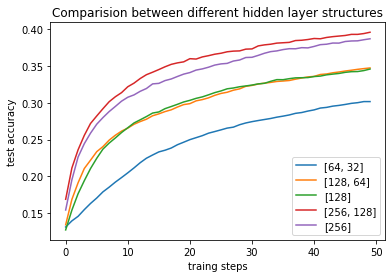

In [ ]:
plt.plot(log0[2], label='[64, 32]')
plt.plot(log1[2], label='[128, 64]')
plt.plot(log1_1[2], label='[128]')
plt.plot(log2[2], label='[256, 128]')
plt.plot(log2_1[2], label='[256]')
plt.title("Comparision between different hidden layer structures")
plt.xlabel("traing steps")
plt.ylabel("test accuracy")
plt.legend()
plt.show()

#### Mini-batch size

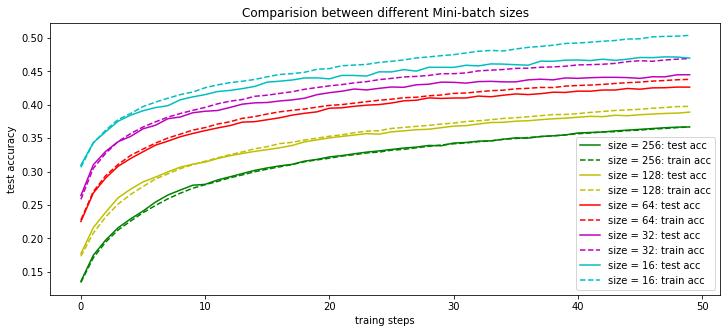

In [ ]:
figure(figsize=(12,5))
plt.plot(log4[2], 'g-', label='size = 256: test acc')
plt.plot(log4[1], 'g--', label='size = 256: train acc')
plt.plot(log2[2], 'y-', label='size = 128: test acc')
plt.plot(log2[1], 'y--', label='size = 128: train acc')
# to avoid introduce additional overfits, we will use 64 as mini-batch size in 
# the following experiments
plt.plot(log3[2], 'r-', label='size = 64: test acc')
plt.plot(log3[1], 'r--', label='size = 64: train acc')
plt.plot(log3_1[2], 'm-', label='size = 32: test acc')
plt.plot(log3_1[1], 'm--', label='size = 32: train acc')
plt.plot(log3_2[2], 'c-', label='size = 16: test acc')
plt.plot(log3_2[1], 'c--', label='size = 16: train acc')
plt.title("Comparision between different Mini-batch sizes")
plt.xlabel("traing steps")
plt.ylabel("test accuracy")
plt.legend()
plt.show()

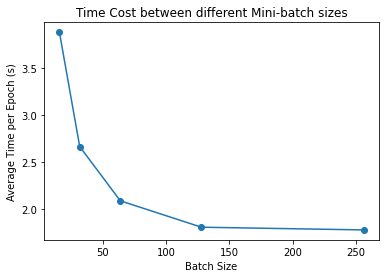

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]
ave_time = [np.mean(log3_2[3]), np.mean(log3_1[3]), np.mean(log3[3]), np.mean(log2[3]),
            np.mean(log4[3])]

plt.plot(batch_sizes, ave_time, marker='o')
plt.title("Time Cost between different Mini-batch sizes")
plt.xlabel("Batch Size")
plt.ylabel("Average Time per Epoch (s)")
plt.show()

#### Momentum

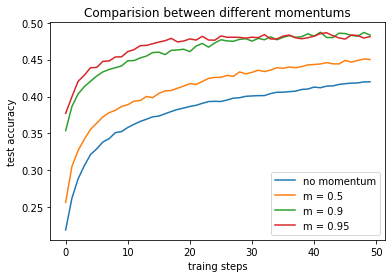

In [ ]:
plt.plot(log3[2], label='no momentum')
plt.plot(log8[2], label='m = 0.5')
plt.plot(log6[2], label='m = 0.9')
plt.plot(log7[2], label='m = 0.95')
plt.title("Comparision between different momentums")
plt.xlabel("traing steps")
plt.ylabel("test accuracy")
plt.legend()
plt.show()

#### SGD

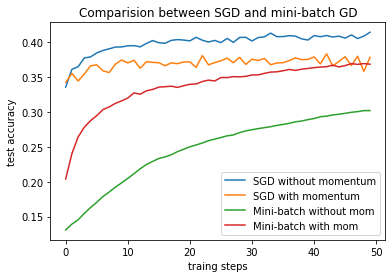

In [ ]:
plt.plot(log5[2], label='SGD without momentum')
plt.plot(log15[2], label='SGD with momentum')
# Mini-batch here is 128
plt.plot(log0[2], label='Mini-batch without mom')
plt.plot(log0_1[2], label='Mini-batch with mom')
plt.title("Comparision between SGD and mini-batch GD")
plt.xlabel("traing steps")
plt.ylabel("test accuracy")
plt.legend()
plt.show()

#### Weight Decay

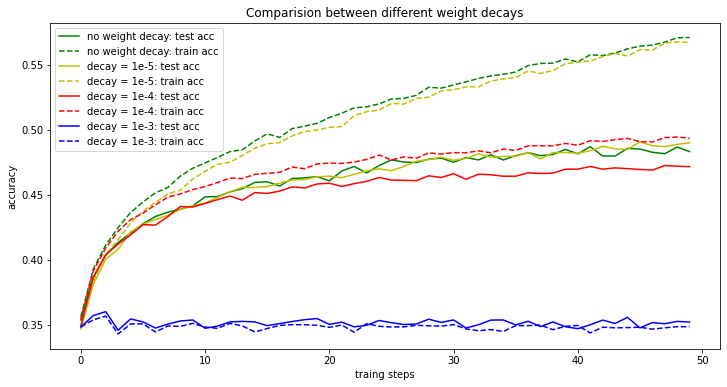

In [ ]:
# decay should be chosed around 1e-4
figure(figsize=(12,6))
plt.plot(log6[2], 'g-', label='no weight decay: test acc')
plt.plot(log6[1], 'g--', label='no weight decay: train acc')
plt.plot(log10_1[2], 'y-', label='decay = 1e-5: test acc')
plt.plot(log10_1[1], 'y--', label='decay = 1e-5: train acc')
plt.plot(log9[2], 'r-', label='decay = 1e-4: test acc')
plt.plot(log9[1], 'r--', label='decay = 1e-4: train acc')
plt.plot(log10[2], 'b-', label='decay = 1e-3: test acc')
plt.plot(log10[1], 'b--', label='decay = 1e-3: train acc')
plt.title("Comparision between different weight decays")
plt.xlabel("traing steps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### Dropout

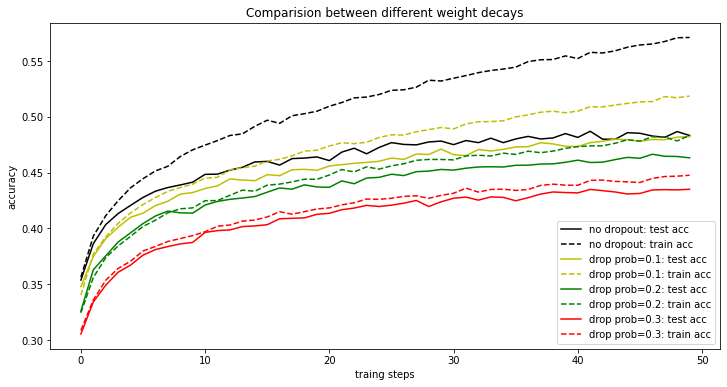

In [ ]:
# the momentom introduced obvious overfitting
figure(figsize=(12,6))
plt.plot(log6[2], 'k-', label='no dropout: test acc')
plt.plot(log6[1], 'k--', label='no dropout: train acc')
plt.plot(log12_1[2], 'y-', label='drop prob=0.1: test acc')
plt.plot(log12_1[1], 'y--', label='drop prob=0.1: train acc')
plt.plot(log11[2], 'g-', label='drop prob=0.2: test acc')
plt.plot(log11[1], 'g--', label='drop prob=0.2: train acc')
plt.plot(log12[2], 'r-', label='drop prob=0.3: test acc')
plt.plot(log12[1], 'r--', label='drop prob=0.3: train acc')

# a dropout between 0.1 ~ 0.2 seems to be a reasonable choise
plt.title("Comparision between different weight decays")
plt.xlabel("traing steps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

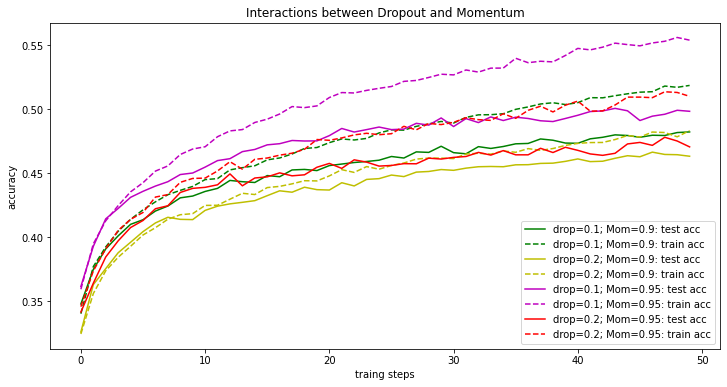

In [ ]:
# the momentom introduced obvious overfitting
figure(figsize=(12,6))
plt.plot(log12_1[2], 'g-', label='drop=0.1; Mom=0.9: test acc')
plt.plot(log12_1[1], 'g--', label='drop=0.1; Mom=0.9: train acc')
plt.plot(log11[2], 'y-', label='drop=0.2; Mom=0.9: test acc')
plt.plot(log11[1], 'y--', label='drop=0.2; Mom=0.9: train acc')
plt.plot(log13_1[2], 'm-', label='drop=0.1; Mom=0.95: test acc')
plt.plot(log13_1[1], 'm--', label='drop=0.1; Mom=0.95: train acc')
plt.plot(log13[2], 'r-', label='drop=0.2; Mom=0.95: test acc')
plt.plot(log13[1], 'r--', label='drop=0.2; Mom=0.95: train acc')

# a dropout between 0.1 ~ 0.2 seems to be a reasonable choise
plt.title("Interactions between Dropout and Momentum")
plt.xlabel("traing steps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### Batch-Normalisation

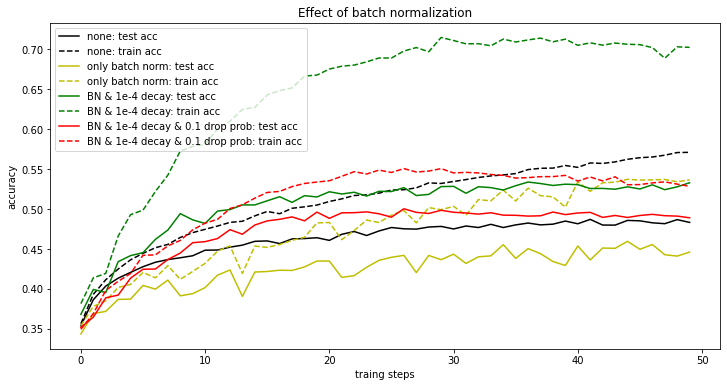

In [ ]:
figure(figsize=(12,6))
plt.plot(log6[2], 'k-', label='none: test acc')
plt.plot(log6[1], 'k--', label='none: train acc')
plt.plot(log14[2], 'y-', label='only batch norm: test acc')
plt.plot(log14[1], 'y--', label='only batch norm: train acc')
plt.plot(log17[2], 'g-', label='BN & 1e-4 decay: test acc')
plt.plot(log17[1], 'g--', label='BN & 1e-4 decay: train acc')
plt.plot(log16[2], 'r-', label='BN & 1e-4 decay & 0.1 drop prob: test acc')
plt.plot(log16[1], 'r--', label='BN & 1e-4 decay & 0.1 drop prob: train acc')

plt.title("Effect of batch normalization")
plt.xlabel("traing steps")
plt.ylabel("accuracy")
plt.legend()
plt.show()